# INIT

In [116]:
import os
import torch
from torchvision import datasets, transforms, models, tv_tensors
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy, multiclass_precision, multiclass_recall, binary_accuracy, binary_f1_score, binary_recall, binary_precision
import clip
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [6]:
print(torch.__version__)
print(np.__version__)

2.2.2
1.26.4


In [7]:
labels = ['no diabetic retinopathy', 
          'mild diabetic retinopathy',
         'moderate diabetic retinopathy',
         'severe diabetic retinopathy',
         'proliferative diabetic retinopathy']

In [8]:
def imshow(image, ax=None, title=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)
    return ax

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [11]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x12538ac00>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [12]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

## Checking CLIP

In [13]:
train = datasets.ImageFolder('./APTOS2019/train', transform=preprocess)

In [14]:
dataloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)

In [21]:
images, y = next(iter(dataloader))

In [22]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c} fundus") for c in labels]).to(device)

In [23]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(images[0].unsqueeze(0))
    text_features = model.encode_text(text_inputs)

In [24]:
# Pick the top n most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(len(labels))

In [25]:
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

mild diabetic retinopathy: 23.18%
proliferative diabetic retinopathy: 22.32%
moderate diabetic retinopathy: 20.16%
severe diabetic retinopathy: 17.21%
no diabetic retinopathy: 17.13%


<Axes: title={'center': 'no diabetic retinopathy'}>

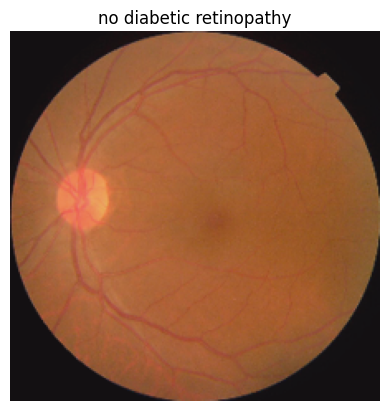

In [27]:
imshow(images[0], title=f'{labels[int(y[0])]}', normalize=True)

# Zero-shot Image Classification with CLIP
[Source](https://www.pinecone.io/learn/series/image-search/zero-shot-image-classification-clip/)

In [137]:
test = datasets.ImageFolder('./APTOS2019/test', transform=preprocess)

In [138]:
dataloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [139]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c} fundus") for c in labels]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [154]:
y_pred = np.ones((len(test))).astype(np.int32)*-1
y_true = np.ones_like(y_pred).astype(np.int32)*-1
for idx, (image, label) in enumerate(dataloader):
    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image[0].unsqueeze(0))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    y_pred[idx] = np.argmax(similarity)
    y_true[idx]=label[0]

In [155]:
y_pred

array([1, 4, 2, 1, 4, 1, 4, 1, 4, 1, 4, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       4, 2, 4, 4, 4, 4, 1, 2, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 4, 1, 4, 1, 4, 4, 4, 2, 2, 2, 2, 4, 4, 1, 1, 4, 4, 1,
       4, 1, 2, 2, 1, 4, 4, 1, 2, 4, 4, 1, 1, 4, 1, 2, 4, 4, 1, 1, 1, 1,
       1, 1, 1, 4, 1, 1, 1, 2, 4, 1, 1, 4, 1, 4, 2, 1, 1, 4, 1, 1, 1, 4,
       1, 1, 4, 1, 1, 4, 4, 2, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1,
       4, 1, 2, 4, 4, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4,
       4, 1, 4, 1, 1, 4, 4, 1, 1, 1, 4, 4, 4, 1, 4, 4, 4, 1, 1, 1, 2, 1,
       1, 4, 1, 1, 1, 4, 1, 1, 4, 1, 1, 2, 1, 1, 1, 4, 4, 1, 2, 1, 1, 4,
       1, 1, 2, 4, 4, 4, 1, 4, 4, 1, 1, 4, 1, 1, 1, 4, 1, 4, 1, 4, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 4, 1, 4, 1, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1,
       2, 4, 1, 4, 1, 4, 2, 4, 1, 1, 1, 1, 4, 4, 4, 1, 2, 1, 1, 4, 1, 1,
       1, 4, 1, 4, 4, 4, 2, 4, 1, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 4, 1, 4,
       1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 1, 4, 4, 2, 4,

In [156]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [157]:
np.sum(y_true == y_pred)/len(y_true)

0.14866310160427806

In [158]:
print(
    f' Accuracy: {multiclass_accuracy(torch.from_numpy(y_pred), torch.from_numpy(y_true))}\n',
    f'Precision: {multiclass_precision(torch.from_numpy(y_pred), torch.from_numpy(y_true))}\n',
    f'Recall: {multiclass_recall(torch.from_numpy(y_pred), torch.from_numpy(y_true))}\n',
    f'F1-score: {multiclass_f1_score(torch.from_numpy(y_pred.astype(np.int64)), torch.from_numpy(y_true.astype(np.int64)), num_classes=5, average=None)}\n',
    f'F1-score (weighted): {multiclass_f1_score(torch.from_numpy(y_pred.astype(np.int64)), torch.from_numpy(y_true.astype(np.int64)), num_classes=5, average='weighted')}'
)

 Accuracy: 0.14866310358047485
 Precision: 0.14866310358047485
 Recall: 0.14866310358047485
 F1-score: tensor([0.0000, 0.2241, 0.1854, 0.0000, 0.1609])
 F1-score (weighted): 0.10139856487512589


Binary classification

In [159]:
bin_y_true = y_true.copy()

In [160]:
bin_y_true[bin_y_true > 0] = 1

In [161]:
print(
    f' Accuracy: {binary_accuracy(torch.from_numpy(y_pred), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Precision: {binary_precision(torch.from_numpy(y_pred), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Recall: {binary_recall(torch.from_numpy(y_pred), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'F1-score: {binary_f1_score(torch.from_numpy(y_pred.astype(np.int64)), torch.from_numpy(bin_y_true),threshold=1)}\n',
)

 Accuracy: 0.5967914462089539
 Precision: 0.5967914462089539
 Recall: 1.0
 F1-score: 0.747488260269165



Another approach to binary classification

In [162]:
binary_labels = [
    'no diabetic retinopathy',
    'diabetic retinopathy'
]

In [163]:
binary_text_inputs = torch.cat([clip.tokenize(f"a photo of a {c} fundus") for c in binary_labels]).to(device)
with torch.no_grad():
    binary_text_features = model.encode_text(binary_text_inputs)
binary_text_features /= binary_text_features.norm(dim=-1, keepdim=True)

In [124]:
bin_y_pred = np.ones((len(test))).astype(np.int32)*-1
for idx, (image, label) in enumerate(dataloader):
    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image[0].unsqueeze(0))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ binary_text_features.T).softmax(dim=-1)
    bin_y_pred[idx] = np.argmax(similarity)

In [125]:
print(
    f' Accuracy: {binary_accuracy(torch.from_numpy(bin_y_pred), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Precision: {binary_precision(torch.from_numpy(bin_y_pred), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Recall: {binary_recall(torch.from_numpy(bin_y_pred), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'F1-score: {binary_f1_score(torch.from_numpy(bin_y_pred.astype(np.int64)), torch.from_numpy(bin_y_true),threshold=1)}\n',
)

 Accuracy: 0.5786096453666687
 Precision: 0.5949074029922485
 Recall: 0.9211469292640686
 F1-score: 0.7229254245758057



In [165]:
thresh_y_pred = y_pred.copy()

In [167]:
thresh_y_pred[thresh_y_pred>0]=1

In [171]:
np.sum(thresh_y_pred == bin_y_pred)/len(thresh_y_pred)

0.9240641711229947

Another approach

In [172]:
binary_labels_2 = [
    'healthy',
    'diabetic retinopathy'
]

In [174]:
binary_text_inputs_2 = torch.cat([clip.tokenize(f"a photo of a {c} fundus") for c in binary_labels_2]).to(device)
with torch.no_grad():
    binary_text_features_2 = model.encode_text(binary_text_inputs_2)
binary_text_features_2 /= binary_text_features_2.norm(dim=-1, keepdim=True)

In [175]:
bin_y_pred_2 = np.ones((len(test))).astype(np.int32)*-1
for idx, (image, label) in enumerate(dataloader):
    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image[0].unsqueeze(0))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ binary_text_features_2.T).softmax(dim=-1)
    bin_y_pred_2[idx] = np.argmax(similarity)

In [176]:
print(
    f' Accuracy: {binary_accuracy(torch.from_numpy(bin_y_pred_2), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Precision: {binary_precision(torch.from_numpy(bin_y_pred_2), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Recall: {binary_recall(torch.from_numpy(bin_y_pred_2), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'F1-score: {binary_f1_score(torch.from_numpy(bin_y_pred_2.astype(np.int64)), torch.from_numpy(bin_y_true),threshold=1)}\n',
)

 Accuracy: 0.4331550896167755
 Precision: 0.5206489562988281
 Recall: 0.6326164603233337
 F1-score: 0.5711973309516907



In [180]:
np.sum(bin_y_pred_2 == bin_y_pred)/len(bin_y_pred)

0.7240641711229947

In [181]:
np.sum(bin_y_pred_2 == thresh_y_pred)/len(bin_y_pred)

0.7251336898395722

How to present two loss functions and saliency maps of CLIP when it's not opensource?